This notebook generates sample data that can be used to illustrate the Cloud ML Ecosystem workflow for using AEP Data for machine learning use cases with external ML tools and platforms. We will generate sample data and perform Data Exploration with the following steps:

- Setup
- Create Experience Event Schema and Dataset
- Create Profile Schema and Dataset
- Statistical simulation of Profiles and Experience Events
- Ingest Synthetic data into AEP dataset
- Data Exploration for Propensity Models
- Analyzing the data



Setup

Before we run anything, make sure to install the following required libraries for this notebook. They are all publicly available libraries and the latest version should work fine.

In [54]:
%pip install mmh3
%pip install rstr
%pip install aepp
%pip install pygresql==5.2.5
%pip install mimesis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


This notebook requires some configuration data to properly authenticate to your Adobe Experience Platform instance. You should be able to find all the values required above by following the Setup section of the **README**.

The next cell will be looking for your configuration file under your **ADOBE_HOME** path to fetch the values used throughout this notebook. See more details in the Setup section of the **README** to understand how to create your configuration file.

In [55]:
import os
from configparser import ConfigParser
import aepp

os.environ["ADOBE_HOME"] = "../../"

if "ADOBE_HOME" not in os.environ:
    raise Exception("ADOBE_HOME environment variable needs to be set.")

config = ConfigParser()
config_file = "config.ini"
config_path = os.path.join(os.environ["ADOBE_HOME"], "conf", config_file)

if not os.path.exists(config_path):
    raise Exception(f"Looking for configuration under {config_path} but config not found, please verify path")

config.read(config_path)

aepp.configure(
  org_id=config.get("Platform", "ims_org_id"),
  tech_id=config.get("Authentication", "tech_acct_id"), 
  secret=config.get("Authentication", "client_secret"),
  scopes=config.get("Authentication", "scopes"),
  client_id=config.get("Authentication", "client_id"),
  environment=config.get("Platform", "environment"),
  sandbox=config.get("Platform", "sandbox_name")
)

To ensure uniqueness of resources created as part of this notebook, we are using your local username to include in each of the resource titles to avoid conflicts.

In [56]:
import re
username = 'amuiaws'
unique_id = s = re.sub("[^0-9a-zA-Z]+", "_", username)

Function to generate link to resource in the UI:

In [57]:
def get_ui_link(tenant_id, resource_type, resource_id):
    environment = config.get("Platform", "environment")
    sandbox_name = config.get("Platform", "sandbox_name")
    if environment == "prod":
        prefix = f"https://experience.adobe.com"
    else:
        prefix = f"https://experience-{environment}.adobe.com"
    return f"{prefix}/#/@{tenant_id}/sname:{sandbox_name}/platform/{resource_type}/{resource_id}"

# 1. Create Experience Event schema and dataset

We will now create the schema to support our synthetic data. We need a few fields which will be included in the synthetic event data:
- Direct Marketing information
- Web details

## 1.1 Create connection to XDM Schema Registry

In [58]:
from aepp import schema
schema_conn = schema.Schema()
schema_conn.sandbox
tenant_id = schema_conn.getTenantId()
tenant_id

'exchangesandboxbravo'

## Create User ID field group for Experience Event Schema

We need to create a custom field group with a `cmle_id` field to go in the experience event schema. Other schema fields will come from standard field field groups we will include when creating the schema.

First we'll define some utility functions to gracefully handle cases where the CMLE User ID field group has already been created:

In [59]:
def getFieldGroupbyTitle(schema_conn: schema.Schema, title: str):
    fieldgroups = schema_conn.getFieldGroups()
    match = list(filter(lambda d: d['title'] == title, fieldgroups))
    if len(match) == 1:
        return match[0]
    else:
        return None

In [60]:
def createFieldGroupifnotExists(schema_conn: schema.Schema, title: str, data: dict):
    existing = getFieldGroupbyTitle(schema_conn, title)
    if existing:
        print(f"'{title}' already exists, retrieving existing field group")
        return existing
    else:
        return schema_conn.createFieldGroup(data)

Create the User ID field group (or retrieve the field group ID if it already exists):

In [61]:
fieldgroup_title = f"[CMLE Synthetic Data] Exp Event User ID (created by {username})"
fieldgroup_data = {
  "type": "object",
	"title": fieldgroup_title,
	"description": "This field group is used to identify the user to whom an experience event belongs.",
	"allOf": [{
		"$ref": "#/definitions/customFields"
	}],
	"meta:containerId": "tenant",
	"meta:resourceType": "mixins",
	"meta:xdmType": "object",
	"definitions": {
      "customFields": {
        "type": "object",
        "properties": {
          f"_{tenant_id}": {
            "type": "object",
            "properties": {
              "cmle_id": {
                "title": "CMLE User ID",
                "description": "Person identifier for CMLE synthetic event data",
                "type": "string"
              }
            }
          }
        }
      }
	},
	"meta:intendedToExtend": ["https://ns.adobe.com/xdm/context/experienceevent"]
}

In [62]:
fieldgroup_res = createFieldGroupifnotExists(schema_conn, fieldgroup_title, fieldgroup_data)
fieldgroup_id = fieldgroup_res['$id']
print(f"User ID field group ID: {fieldgroup_id}")

# Get link to field group in AEP UI
import urllib.parse
fieldgroup_link = get_ui_link(tenant_id, "schema/mixin/browse", urllib.parse.quote(fieldgroup_id, safe="a"))
print(f"View field group in UI: {fieldgroup_link}")

User ID field group ID: https://ns.adobe.com/exchangesandboxbravo/mixins/65fb685dbdbf67597dd4deb8b748e5a6264477a2d30cb7f
View field group in UI: https://experience.adobe.com/#/@exchangesandboxbravo/sname:amanzonpaymentssandboxae/platform/schema/mixin/browse/https%3A%2F%2Fns.adobe.com%2Fexchangesandboxbravo%2Fmixins%2F65fb685dbdbf67597dd4deb8b748e5a6264477a2d30cb7f


## 1.2 Compose Experience Event schema

Now we'll create the experience event schema from our custom field group and the following standard field groups:
- Direct Marketing Details
- Web Details

First we'll define some utility functions to gracefully handle cases where the Experience Event schema has already been created:

In [63]:
def getSchemabyTitle(schema_conn: schema.Schema, title: str):
    schemas = schema_conn.getSchemas()
    # Handle case where no schemas have been created
    if 'results' in schemas: 
        return None
    # Filter schemas list for matching title
    match = list(filter(lambda d: d['title'] == title, schemas))
    # XDM schema titles must be unique, so 'match' will have exactly 1 element if a schema
    # with the same title already exists
    if len(match) == 1:
        return match[0]
    else:
        return None

In [64]:
def createSchemaifnotExists(schema_conn: schema.Schema, title: str, fieldGroups: list[str], description: str = "", type: str = "event"):
    existing = getSchemabyTitle(schema_conn, title)
    if existing:
        print(f"'{title}' already exists, retrieving existing schema")
        return existing
    else:
        if type == "event":
            return schema_conn.createExperienceEventSchema(
                name=title,
                fieldGroupIds=fieldGroups,
                description=description
            )
        elif type =="profile":
            return schema_conn.createProfileSchema(
                name=title,
                fieldGroupIds=fieldGroups,
                description=description
            )
        else:
            raise AttributeError('"type" must be "event" (default) or "profile"')


Create the Experience Event schema (or retrieve the ID and Alt ID if the schema already exists):

In [65]:
schema_ee_title = f"[CMLE Synthetic Data] Experience Event schema (created by {username})"
schema_ee_fgs = [
    fieldgroup_id,
    "https://ns.adobe.com/xdm/context/experienceevent-directmarketing",
    "https://ns.adobe.com/xdm/context/experienceevent-web"
]
schema_ee_desc = "Profile Schema generated by CMLE for synthetic events"

In [66]:
schema_ee_res = createSchemaifnotExists(
    schema_conn=schema_conn,
    title=schema_ee_title,
    fieldGroups=schema_ee_fgs,
    description=schema_ee_desc
)
schema_ee_id = schema_ee_res['$id']
schema_ee_altId = schema_ee_res["meta:altId"]
print(f"EE Schema ID: {schema_ee_id}")
print(f"EE Schema Alt ID: {schema_ee_altId}")

schema_ee_link = get_ui_link(tenant_id, "schema/mixin/browse", urllib.parse.quote(schema_ee_id, safe="a"))
print(f"View EE schema in UI: {schema_ee_link}")

EE Schema ID: https://ns.adobe.com/exchangesandboxbravo/schemas/1bd309c04dc83e2fa319da48ed4c3e7a19884ab092bee5d4
EE Schema Alt ID: _exchangesandboxbravo.schemas.1bd309c04dc83e2fa319da48ed4c3e7a19884ab092bee5d4
View EE schema in UI: https://experience.adobe.com/#/@exchangesandboxbravo/sname:amanzonpaymentssandboxae/platform/schema/mixin/browse/https%3A%2F%2Fns.adobe.com%2Fexchangesandboxbravo%2Fschemas%2F1bd309c04dc83e2fa319da48ed4c3e7a19884ab092bee5d4


Set "cmle_id" as the primary ID for the schema with ECID as the namespace

In [67]:
identity_type = "ECID"
identity_desc_data = {
    "@type": "xdm:descriptorIdentity",
    "xdm:sourceSchema": schema_ee_id,
    "xdm:sourceVersion": 1,
    "xdm:sourceProperty": f"/_{tenant_id}/cmle_id",
    "xdm:namespace": identity_type,
    "xdm:property": "xdm:id",
    "xdm:isPrimary": True
  }
identity_dsc_ee_res = schema_conn.createDescriptor(
    descriptorObj = identity_desc_data
)
identity_dsc_ee_res

{'@id': '906eeff904a6de01c3d6035921fb9788f32dec1ab3a250b9',
 '@type': 'xdm:descriptorIdentity',
 'xdm:sourceSchema': 'https://ns.adobe.com/exchangesandboxbravo/schemas/1bd309c04dc83e2fa319da48ed4c3e7a19884ab092bee5d4',
 'xdm:sourceVersion': 1,
 'xdm:sourceProperty': '/_exchangesandboxbravo/cmle_id',
 'imsOrg': 'EFE243245DB9D3DD0A495E80@AdobeOrg',
 'version': '1',
 'xdm:namespace': 'ECID',
 'xdm:property': 'xdm:id',
 'xdm:isPrimary': True,
 'meta:containerId': 'e0b17021-6875-424f-b170-216875124f2d',
 'meta:sandboxId': 'e0b17021-6875-424f-b170-216875124f2d',
 'meta:sandboxType': 'development'}

Enable EE schema for Profile

In [68]:
enable_ee_res = schema_conn.enableSchemaForRealTime(schema_ee_altId)
enable_ee_res

{'$id': 'https://ns.adobe.com/exchangesandboxbravo/schemas/1bd309c04dc83e2fa319da48ed4c3e7a19884ab092bee5d4',
 'meta:altId': '_exchangesandboxbravo.schemas.1bd309c04dc83e2fa319da48ed4c3e7a19884ab092bee5d4',
 'meta:resourceType': 'schemas',
 'version': '1.1',
 'title': '[CMLE Synthetic Data] Experience Event schema (created by amuiaws)',
 'type': 'object',
 'description': 'Profile Schema generated by CMLE for synthetic events',
 'allOf': [{'$ref': 'https://ns.adobe.com/xdm/context/experienceevent',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/exchangesandboxbravo/mixins/65fb685dbdbf67597dd4deb8b748e5a6264477a2d30cb7f',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/xdm/context/experienceevent-directmarketing',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/xdm/context/experienceevent-web',
   'type': 'object',
   'meta:xdmType': 'object'}],
 'refs': ['https://ns.adobe.com/xdm

## 1.3 Create Experience Event dataset

First, create a connection to the Catalog API

In [69]:
from aepp import catalog
cat_conn = catalog.Catalog()

Define some utility functions to gracefully handle cases where the Experience Event dataset has alrerady been created:

In [70]:
def getDatasetbyName(cat_conn: catalog.Catalog, name: str):
    datasets = cat_conn.getDataSets()
    match = {k:v for k, v in datasets.items() if v['name'] == name}
    if match:
        return list(match.keys())[0]
    else:
        return None

In [71]:
def createDatasetifNotExists(cat_conn: catalog.Catalog, name: str, schemaId: str):
    existing = getDatasetbyName(cat_conn=cat_conn, name=name)
    if existing:
        return existing
    else:
        dataset = cat_conn.createDataSets(name=name, schemaId=schemaId)
        return dataset[0].split("/")[-1]

Create the Experience Event dataset

In [72]:
dataset_ee_name = f"[CMLE Synthetic Data] Experience Event dataset (created by {username})"
dataset_ee_id = createDatasetifNotExists(cat_conn=cat_conn, name=dataset_ee_name, schemaId=schema_ee_id)
print(f"EE Dataset ID: {dataset_ee_id}")

dataset_ee_link = get_ui_link(tenant_id, "dataset/browse", dataset_ee_id)
print(f"View EE Dataset in UI: {dataset_ee_link}")


EE Dataset ID: 65041e9543f31128d339937c
View EE Dataset in UI: https://experience.adobe.com/#/@exchangesandboxbravo/sname:amanzonpaymentssandboxae/platform/dataset/browse/65041e9543f31128d339937c


Enable dataset for Profile
<div class="alert alert-block alert-warning">
<b>Note:</b> After you do this step please go in the UI and click on the link above, if the profile toggle is not enabled please manually toggle the profile on
</div>

In [73]:
cat_conn.enableDatasetProfile(dataset_ee_id)

['@/dataSets/65041e9543f31128d339937c']

# 2. Create Profile schema and dataset

The Profile schema will include the following field groups:
- Loyalty Details
- Personal Contact Details
- Demographic Details
- User Account Details

## 2.1 Create Profile schema

In [74]:
# Set schema parameters
schema_profile_title = f"[CMLE Synthetic Data] Profile Schema (created by {username})"
schema_profile_fgs = [
    'https://ns.adobe.com/xdm/mixins/profile/profile-loyalty-details',
    'https://ns.adobe.com/xdm/context/profile-personal-details',
    'https://ns.adobe.com/xdm/context/profile-person-details',
    'https://ns.adobe.com/xdm/mixins/profile/profile-user-account-details'
]
schema_profile_desc = "Profile Schema generated by CMLE"

In [75]:
schema_profile_res = createSchemaifnotExists(
    schema_conn=schema_conn,
    title=schema_profile_title,
    fieldGroups=schema_profile_fgs,
    description=schema_profile_desc,
    type="profile"
)
schema_profile_id = schema_profile_res['$id']
schema_profile_altId = schema_profile_res["meta:altId"]
print(f"Profile Schema ID: {schema_profile_id}")
print(f"Profile Schema Alt ID: {schema_profile_altId}")

schema_profile_link = get_ui_link(tenant_id, "schema/mixin/browse", urllib.parse.quote(schema_profile_id, safe="a"))
print(f"View Profile schema in UI: {schema_profile_link}")

Profile Schema ID: https://ns.adobe.com/exchangesandboxbravo/schemas/e1e376dc3ce15900eaf35180c74c9b05f8c0f6ff280a2dd0
Profile Schema Alt ID: _exchangesandboxbravo.schemas.e1e376dc3ce15900eaf35180c74c9b05f8c0f6ff280a2dd0
View Profile schema in UI: https://experience.adobe.com/#/@exchangesandboxbravo/sname:amanzonpaymentssandboxae/platform/schema/mixin/browse/https%3A%2F%2Fns.adobe.com%2Fexchangesandboxbravo%2Fschemas%2Fe1e376dc3ce15900eaf35180c74c9b05f8c0f6ff280a2dd0


Set `personID` as the primary ID for the schema with ECID as the namespace

In [76]:
identity_type = "ECID"
identity_desc_data = {
    "@type": "xdm:descriptorIdentity",
    "xdm:sourceSchema": schema_profile_id,
    "xdm:sourceVersion": 1,
    "xdm:sourceProperty": f"/personID",
    "xdm:namespace": identity_type,
    "xdm:property": "xdm:id",
    "xdm:isPrimary": True
  }
identity_dsc_profile_res = schema_conn.createDescriptor(
    descriptorObj = identity_desc_data
)
identity_dsc_profile_res

{'@id': 'ac1a9170ee800b89aa1193e1d37c7398295a2b2837d331dd',
 '@type': 'xdm:descriptorIdentity',
 'xdm:sourceSchema': 'https://ns.adobe.com/exchangesandboxbravo/schemas/e1e376dc3ce15900eaf35180c74c9b05f8c0f6ff280a2dd0',
 'xdm:sourceVersion': 1,
 'xdm:sourceProperty': '/personID',
 'imsOrg': 'EFE243245DB9D3DD0A495E80@AdobeOrg',
 'version': '1',
 'xdm:namespace': 'ECID',
 'xdm:property': 'xdm:id',
 'xdm:isPrimary': True,
 'meta:containerId': 'e0b17021-6875-424f-b170-216875124f2d',
 'meta:sandboxId': 'e0b17021-6875-424f-b170-216875124f2d',
 'meta:sandboxType': 'development'}

Enable EE schema for Profile

In [77]:
enable_profile_res = schema_conn.enableSchemaForRealTime(schema_profile_altId)
enable_profile_res

{'$id': 'https://ns.adobe.com/exchangesandboxbravo/schemas/e1e376dc3ce15900eaf35180c74c9b05f8c0f6ff280a2dd0',
 'meta:altId': '_exchangesandboxbravo.schemas.e1e376dc3ce15900eaf35180c74c9b05f8c0f6ff280a2dd0',
 'meta:resourceType': 'schemas',
 'version': '1.1',
 'title': '[CMLE Synthetic Data] Profile Schema (created by amuiaws)',
 'type': 'object',
 'description': 'Profile Schema generated by CMLE',
 'allOf': [{'$ref': 'https://ns.adobe.com/xdm/context/profile',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/xdm/mixins/profile/profile-loyalty-details',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/xdm/context/profile-personal-details',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/xdm/context/profile-person-details',
   'type': 'object',
   'meta:xdmType': 'object'},
  {'$ref': 'https://ns.adobe.com/xdm/mixins/profile/profile-user-account-details',
   'type': 'object',
   'met

## 2.2 Create Profile dataset

Create the Profile dataset

In [78]:
dataset_profile_name = f"[CMLE Synthetic Data] Profile dataset (created by {username})"
dataset_profile_id = createDatasetifNotExists(cat_conn=cat_conn, name=dataset_profile_name, schemaId=schema_profile_id)
print(f"Profile Dataset ID: {dataset_profile_id}")

dataset_profile_link = get_ui_link(tenant_id, "dataset/browse", dataset_profile_id)
print(f"View Profile Dataset in UI: {dataset_profile_link}")


Profile Dataset ID: 65041e97c8230928d32cabd9
View Profile Dataset in UI: https://experience.adobe.com/#/@exchangesandboxbravo/sname:amanzonpaymentssandboxae/platform/dataset/browse/65041e97c8230928d32cabd9


Enable dataset for Profile
<div class="alert alert-block alert-warning">
<b>Note:</b> After you do this step please go in the UI and click on the link above, if the profile toggle is not enabled please manually toggle the profile on
</div>

In [79]:
cat_conn.enableDatasetProfile(dataset_profile_id)

['@/dataSets/65041e97c8230928d32cabd9']

# 3. Statistical simulation of Profiles and Experience Events

We will set up a statistical simulation to generate Experience event data that can be used illustrate the end-to-end flow of creating a propensity model to predict subscriptions to a brand's paid service.

We will use the standard `web.formFilledOut` event type to represent the subscription conversions that the brand wants to predict, and generate similulated sequences of various types of experience events along with the target subscription conversions that will be used to train a propensity model.

## 3.1 Event types and their contribution to propensity


In [80]:
import random, string
import uuid
from datetime import timedelta
import mmh3
from random import randrange

Define some events and dependencies between the events

In [81]:
advertising_events = {
 
    #eventType          : (weeklyAverageOccurrence, propensityDelta, [(field_to_replace, value)], timeInHoursFromDependent)
    "advertising.clicks": (0.01,                    0.002,            [("advertising/clicks/value", 1.0)], 0.5) , 
    "advertising.impressions": (0.1, 0.001, [("advertising/impressions/value", 1.0)], 0),

    "web.webpagedetails.pageViews": (0.1, 0.005, [("web/webPageDetails/pageViews/value", 1.0)], 0.1),
    "web.webinteraction.linkClicks": (0.05, 0.005, [("web/webInteraction/linkClicks/value", 1.0)], 0.1),
   
    
    "commerce.productViews": (0.05, 0.005, [("commerce/productViews/value", 1.0)], 0.2),
    "commerce.purchases": (0.01, 0.1, [("commerce/purchases/value", 1.0)], 1),
    
    
    "decisioning.propositionDisplay": (0.05, 0.005, [("_experience/decisioning/propositionEventType/display", 1)], 0.1),
    "decisioning.propositionInteract": (0.01, 0.1, [("_experience/decisioning/propositionEventType/interact", 1)], 0.05),
    "decisioning.propositionDismiss": (0.01, -0.2, [("_experience/decisioning/propositionEventType/dismiss", 1)], 0.05),

    
    "directMarketing.emailOpened": (0.2, 0.02, [("directMarketing/opens/value", 1.0)], 24),
    "directMarketing.emailClicked": (0.05, 0.1, [("directMarketing/clicks/value", 1.0)], 0.5),
    "directMarketing.emailSent": (0.5, 0.005, [("directMarketing/sends/value", 1.0)], 0),
    
    "web.formFilledOut": (0.0, 0.0, [("web/webPageDetails/name", "subscriptionForm")], 0),

}

event_dependencies = {
    "advertising.impressions": ["advertising.clicks"],
    "directMarketing.emailSent": ["directMarketing.emailOpened"],
    "directMarketing.emailOpened": ["directMarketing.emailClicked"],
    "directMarketing.emailClicked": ["web.webpagedetails.pageViews"],
    "web.webpagedetails.pageViews": ["web.webinteraction.linkClicks", "commerce.productViews", "decisioning.propositionDisplay"],
    "commerce.productViews": ["commerce.purchases"],
    "decisioning.propositionDisplay": ["decisioning.propositionInteract", "decisioning.propositionDismiss"]
    
}

Define utility functions that will be used to implement the event simulation

In [82]:
import numpy as np
from datetime import datetime

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

## 3.2 Event generation process

In [83]:

def create_data_for_n_users(n_users, first_user):
  
  N_USERS = n_users
  FIRST_USER = first_user
  
  N_WEEKS = 10
  GLOBAL_START_DATE = datetime.now() - timedelta(weeks=12)
  GLOBAL_END_DATE = GLOBAL_START_DATE + timedelta(weeks=N_WEEKS)

  events = []

  for user in range(N_USERS):
        user_id = FIRST_USER + user
        user_events = []
        base_events = {}
        for event_type in ["advertising.impressions", "web.webpagedetails.pageViews", "directMarketing.emailSent"]:
            n_events = np.random.poisson(advertising_events[event_type][0] * N_WEEKS)
            times = []
            for _ in range(n_events):
                #times.append(random_date(GLOBAL_START_DATE, GLOBAL_END_DATE)
                times.append(random_date(GLOBAL_START_DATE, GLOBAL_END_DATE).isoformat())

            base_events[event_type] = times

        for event_type, dependent_event_types in event_dependencies.items():

            if event_type in base_events:
                #for each originating event
                for event_time in base_events[event_type]:
                    #Look for possible later on events
                    for dependent_event in dependent_event_types:
                                n_events = np.random.poisson(advertising_events[dependent_event][0] * N_WEEKS)
                                times = []
                                for _ in range(n_events):
                                    #times.append(event_time + timedelta(hours = np.random.exponential(advertising_events[dependent_event][3])))
                                    new_time = datetime.fromisoformat(event_time) + timedelta(hours = np.random.exponential(advertising_events[dependent_event][3]))
                                    times.append(new_time.isoformat())
                                base_events[dependent_event] = times


        for event_type, times in base_events.items():
            for time in times:
                user_events.append({"cmle_id": user_id, "eventType": event_type, "timestamp": time})

        user_events = sorted(user_events, key = lambda x: (x["cmle_id"], x["timestamp"]))


        cumulative_probability = 0.001
        subscribed = False
        for event in user_events:
            cumulative_probability = min(1.0, max(cumulative_probability + advertising_events[event["eventType"]][1], 0))
            event["subscriptionPropensity"] = cumulative_probability
            if subscribed == False and "directMarketing" not in event["eventType"] and "advertising" not in event["eventType"]:
                subscribed = np.random.binomial(1, cumulative_probability) > 0
                if subscribed:
                    subscriptiontime = (datetime.fromisoformat(event["timestamp"]) + timedelta(seconds = 60)).isoformat()
                    #subscriptiontime = event["timestamp"] + timedelta(seconds = 60)
                    user_events.append({"cmle_id": user_id, "eventType": "web.formFilledOut",  "timestamp": subscriptiontime})
            event["subscribed"] = subscribed
        user_events = sorted(user_events, key = lambda x: (x["cmle_id"], x["timestamp"]))

        events = events + user_events
  return events

In [84]:
def normalize_ecid(ecid_part):
    ecid_part_str = str(abs(ecid_part))
    if len(ecid_part_str) != 19:
        ecid_part_str = "".join([str(x) for x in range(
            0, 19 - len(ecid_part_str))]) + ecid_part_str
    return ecid_part_str

In [85]:

def get_ecid(user_id):
    """
    The ECID must be two valid 19 digit longs concatenated together
    """
    email = f"synthetic-user-{user_id}@adobe.com"
    ecidpart1, ecidpart2 = mmh3.hash64(email)
    ecid1, ecid2 = (normalize_ecid(ecidpart1), normalize_ecid(ecidpart2))
    return ecid1 + ecid2

In [86]:
# Define the data that goes into an email event payload
def create_email_event(user_id, event_type, timestamp):
  """
  Combines previous methods to create various type of email events
  """
  
  if event_type == "directMarketing.emailSent":
    directMarketing = {"emailDelivered": {"value": 1.0}, 
                       "sends": {"value": 1.0}, 
                       "emailVisitorID": user_id,
                       "hashedEmail": ''.join(random.choices(string.ascii_letters + string.digits, k=10)),
                       "messageID": str(uuid.uuid4()),
                      }
  elif event_type == "directMarketing.emailOpened":
    directMarketing = {"offerOpens": {"value": 1.0}, 
                     "opens": {"value": 1.0}, 
                     "emailVisitorID": user_id,
                     "messageID": str(uuid.uuid4()),
                    }
  elif event_type == "directMarketing.emailClicked":
    directMarketing = {"clicks": {"value": 1.0}, 
                     "offerOpens": {"value": 1.0}, 
                     "emailVisitorID": user_id,
                     "messageID": str(uuid.uuid4()),
                    }
  return {
    "directMarketing": directMarketing,
    "web": None,
    "_id": str(uuid.uuid4()),
    "eventMergeId": None,
    "eventType": event_type,
    f"_{tenant_id}": {"cmle_id":get_ecid(user_id)},
    "producedBy": "databricks-synthetic",
    "timestamp": timestamp
  }

In [87]:
# Define the data that goes into a web event payload 
def create_web_event(user_id, event_type, timestamp):
  """
  Combines previous methods to creat various type of web events
  """
  url = f"http://www.{''.join(random.choices(string.ascii_letters + string.digits, k=5))}.com"
  ref_url = f"http://www.{''.join(random.choices(string.ascii_letters + string.digits, k=5))}.com"
  name = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
  isHomePage = random.choice([True, False])
  server = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
  site_section = ''.join(random.choices(string.ascii_letters, k=2))
  view_name = ''.join(random.choices(string.ascii_letters, k=3))
  region = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
  interaction_type = random.choice(["download", "exit", "other"])
  web_referrer = random.choice(["internal", "external", "search_engine", "email", "social", "unknown", "usenet", "typed_bookmarked"])
  base_web = {"webInteraction": {"linkClicks": {"value": 0.0}, 
                                 "URL": url, 
                                 "name": name,
                                "region": region,
                                "type": interaction_type},
              "webPageDetails": {"pageViews": {"value": 1.0},
                                 "URL": url,
                                 "isErrorPage": False,
                                 #"isHomepage": isHomePage,
                                 "name": name,
                                 "server": server,
                                 "siteSection": site_section,
                                 "viewName": view_name
                                },
              "webReferrer": {
                "URL": ref_url,
                "type": web_referrer
              }
             }
  if event_type in ["advertising.clicks", "commerce.purchases", "web.webinteraction.linkClicks", "web.formFilledOut", 
                   "decisioning.propositionInteract", "decisioning.propositionDismiss"]:
    base_web["webInteraction"]["linkClicks"]["value"] = 1.0

  return {
    "directMarketing": None,
    "web": base_web,
    "_id": str(uuid.uuid4()),
    "eventMergeId": None,
    "eventType": event_type,
    f"_{tenant_id}": {"cmle_id":get_ecid(user_id)},
    "producedBy": "databricks-synthetic",
    "timestamp": timestamp
  }

In [88]:
    
def create_xdm_event(user_id, event_type, timestamp):
  """
  The final 'event factory' method that converts an event into an XDM event
  """
  if "directMarketing" in event_type:
    return create_email_event(user_id, event_type, timestamp)
  else: 
    return create_web_event(user_id, event_type, timestamp)

In [89]:
def createEventsBatch(n_users, first_user):
    batch_events = create_data_for_n_users(n_users, first_user)
    batch_data = [create_xdm_event(x["cmle_id"], x["eventType"], x["timestamp"]) for x in batch_events]
    return batch_data

## 3.3 Profile generation

The following function generates a set of profiles for populating the Profile dataset

In [90]:
from mimesis import Schema, Field, Locale
import time
def createProfilesBatch(n_users, first_user):

    N_USERS = n_users
    FIRST_USER = first_user
    u = 'u' + str(int(time.time()))

    #field = mimesis.Field(Locale.EN)
    field = Field(Locale.EN)
    #profile_schema = mimesis.Schema(
    profile_schema = Schema(
        schema=lambda: {
            "personID": get_ecid(FIRST_USER + field("increment", accumulator=u) - 1),
            "person": {
                "name": {
                    "firstName": field("first_name"),
                    "lastName": field("last_name")
                },
                "gender": field("choice", items=['male', 'female', 'not_specified'])
            },
            "personalEmail": {
                "address": field("email", domains=["emailsim.io"]),
            },
            "mobilePhone": {
                "number": field("telephone", mask="###-###-####")
            },
            "homeAddress": {
                "street1": field("address"),
                "city": field("city"),
                "state": field("state", abbr=True),
                "postalCode": field("postal_code")
            },
            "loyalty": {
                "loyaltyID": [field("integer_number", start=5000000, end=6000000)],
                "tier": field("choice", items=["diamond", "platinum", "gold", "silver", "member"]),
                "points": field("integer_number", start=0, end=1000000), 
                "joinDate": field("datetime", start=2000, end=2023).strftime("%Y-%m-%dT%H:%M:%SZ")
            }
        },
        iterations=N_USERS
    )
    return profile_schema.create()

# 4. Ingest sythetic data into AEP dataset

We'll now use the functions defined above to simulate sequences of Experience Events for a number of users, then ingest the simulated event data into the Experience Event dataset we create above.

For each batch, we will:
1. Initialize a batch to ingest to our Experience Event dataset
2. Generate a sequence of simulate events using the `create_data_for_n_users` function
3. Format the events into XDM Experience Event payloads using the `create_xdm_event` function
4. Add the synthetic data to the batch
5. Close the batch

First create a connection to the AEP batch ingestion API:

In [91]:
from aepp import ingestion
ingest_conn = ingestion.DataIngestion()

In [92]:
def ingestBatch(
        ingest_conn: ingestion.DataIngestion,
        dataset_id: str,
        data: list[dict]):
    # Initialize batch creation
    batch_res = ingest_conn.createBatch(
        datasetId = dataset_ee_id
    )
    batch_id = batch_res["id"]
    # Upload data
    file_path = f"batch-synthetic-{batch_id}"
    ingest_conn.uploadSmallFile(
        batchId = batch_id,
        datasetId = dataset_id,
        filePath = file_path,
        data = data
    )
    # Complete the batch
    ingest_conn.uploadSmallFileFinish(
        batchId = batch_id
    )
    return batch_id

In [93]:
def ingestSyntheticBatches(
        ingest_conn: ingestion.DataIngestion,
        n_users: int = 10000,
        n_batches: int = 10,
        event_dataset_id: str = None,
        profile_dataset_id: str = None
):
    if event_dataset_id is None and profile_dataset_id is None:
        raise AttributeError('At least one of "event_dataset_id" or "profile_dataset_id" must be provided')
    event_batch_ids = []
    profile_batch_ids = []
    for b in range(n_batches):
        first_user = b * n_users
        if event_dataset_id is not None:
            event_batch = createEventsBatch(n_users, first_user)
            event_batch_id = ingestBatch(ingest_conn, event_dataset_id, event_batch)
            print(f"Processing events batch {b + 1}/{n_batches} with ID {event_batch_id}")
            event_batch_ids.append(event_batch_id)
        if profile_dataset_id is not None:
            profile_batch = createProfilesBatch(n_users, first_user)
            profile_batch_id = ingestBatch(ingest_conn, profile_dataset_id, profile_batch)
            print(f"Processing profiles batch {b + 1}/{n_batches} with ID {profile_batch_id}")
            profile_batch_ids.append(profile_batch_id)
    return (event_batch_ids, profile_batch_ids)


Then repeat the sequences of actions described above to generate and ingest simulated events for the desired number of batches.

In [98]:
num_batches = 10
batch_size = 10000

event_batches, profile_batches = ingestSyntheticBatches(
    ingest_conn=ingest_conn,
    n_users=batch_size,
    n_batches=num_batches,
    event_dataset_id=dataset_ee_id,
    profile_dataset_id=dataset_profile_id
)
print(event_batches)
print(profile_batches)

Processing events batch 1/10 with ID 01HAC1Q5ATGPET5KEZ7Y16D5ZC
Processing profiles batch 1/10 with ID 01HAC1QAVDPXYGDB2KDEB7RJ8A
Processing events batch 2/10 with ID 01HAC1QKG4XVQDD6FCKKNXH7GE
Processing profiles batch 2/10 with ID 01HAC1QRW0X6R6E72QG72KHEVN
Processing events batch 3/10 with ID 01HAC1R1846HBMPH3S2RETZM5V
Processing profiles batch 3/10 with ID 01HAC1R6KTYKY6A8GR94NP1V97
Processing events batch 4/10 with ID 01HAC1RFFXBMGWJWEXXF1DDQZ5
Processing profiles batch 4/10 with ID 01HAC1RSHMA28VBM77FTCV42D1
Processing events batch 5/10 with ID 01HAC1S25K8VC5Q4SA6XHZJH31
Processing profiles batch 5/10 with ID 01HAC1SBMTA3FK8V58PJJ9ZA0N
Processing events batch 6/10 with ID 01HAC1SMESCZF9QSNN3C63HYZ6
Processing profiles batch 6/10 with ID 01HAC1ST0AFS0CS5Z17ZJKH8FE
Processing events batch 7/10 with ID 01HAC1T2Z97Q26Z688YJYH2950
Processing profiles batch 7/10 with ID 01HAC1T8Y9G197KFVT9J3X4YM8
Processing events batch 8/10 with ID 01HAC1THQKWTMYG17ZYE731PH1
Processing profiles batch 

**Note**: Batches are ingested asynchronously in AEP. It may take some time for all the data generated here to be available in your dataset depending on how your AEP organization has been provisioned. You can check ingestion status for all your batches in [the dataset page of your AEP UI](https://experience.adobe.com/#/@TENANT/sname:SANDBOX/platform/dataset/browse/DATASETID)

You can also check the ingestion status from the notebook by running the following cell:

In [ ]:
from aepp import catalog
import time
cat_conn = catalog.Catalog()

all_ingested = False
while not all_ingested:
  incomplete_batches = cat_conn.getBatches(
    limit=min(100, num_batches),
    n_results=num_batches,
    output="dataframe",
    dataSet=dataset_profile_id,
    status="staging"
  )
  
  num_incomplete_batches = len(incomplete_batches)
  if num_incomplete_batches == 0:
    print("All batches have been ingested")
    all_ingested = True
  else:
    print(f"Remaining batches being ingested: {num_incomplete_batches}")
    time.sleep(30)

# 5. Data Exploration for Propensity Models

In this notebook, we connect to the query service using the aepp library, and examine the data that we have uploaded. 

We do the following steps:

- Connect to query service using the aepp configuration parameters
- Discover the schema of data, and explore a few rows
- Compute basic statistics
- Examine correlations among features, to inform feature creation

## 5.1 Interactive Session with Data Distiller

Every dataset ID in the Adobe Experience Platform is tied to a table name in Query Service world. We can easily get the table name by doing a lookup on the dataset ID and extracting the table name from the tags:
We will be using the dataset created in 1.2.1, please make sure dataset_id is set with the correct value

In [6]:
from aepp import catalog

cat_conn = catalog.Catalog()
dataset_id = dataset_ee_id
dataset_info = cat_conn.getDataSet(dataset_id)
table_name = dataset_info[dataset_id]["tags"]["adobe/pqs/table"][0]
table_name

'cmle_week1_new_notebook_with_ecid_used_dataset_created_by_saikat'

When you set the connection to the query service object you'll setup a connection to the actual table you need to connect to, this will be faster and use up less resources from the query service API

In [7]:
from aepp import queryservice
sandbox_name = config.get("Platform", "sandbox_name")
qs_conn = queryservice.QueryService().connection()
qs_conn["dbname"] = f"{sandbox_name}:{table_name}"
qs_cursor = queryservice.InteractiveQuery(qs_conn)

## 5.2 Querying the dataset

We can use the interactive session created just before to issue any kinds of queries to Query Service. As an example here we simply select all the fields in our synthetic data table.

In [8]:
sample_experience_event_query = f'''SELECT * FROM {table_name} LIMIT 5'''
qs_cursor.query(sample_experience_event_query)

,_aamds,_id,directMarketing,eventMergeId,eventType,producedBy,timestamp,web
0,(65243412659796291646255339364107433273),e5134037-8569-4aad-bbef-279bb831808f,"(NULL,""(1.0)"",synthetic-user-5429@adobe.com,MD...",None,directMarketing.emailSent,databricks-synthetic,2023-01-21 00:01:41.534,None
1,(49844234781406159997650770259889908940),e1793fdc-4ac7-49c6-9aa3-e0867aa0ec55,None,None,commerce.productViews,databricks-synthetic,2023-01-21 00:02:15.916,"(""(http://www.SxTqn.com,""(0.0)"",t91jg,n7Gcl,ex..."
2,(12020984676794453631540776783207087622),78ee3b46-c3fd-4058-8041-f7fe15180268,"(NULL,""(1.0)"",synthetic-user-7954@adobe.com,re...",None,directMarketing.emailSent,databricks-synthetic,2023-01-21 00:02:34.534,None
3,(21690903347635878125817940858837590243),d46358de-d9bf-4bc7-861a-cc3275203fde,"(NULL,""(1.0)"",synthetic-user-3552@adobe.com,5N...",None,directMarketing.emailSent,databricks-synthetic,2023-01-21 00:02:36.534,None
4,(53459861322107555163196673979056455929),5af2c15c-ec23-4a41-ac3d-1dab9fe9a057,"(NULL,""(1.0)"",synthetic-user-5914@adobe.com,YB...",None,directMarketing.emailSent,databricks-synthetic,2023-01-21 00:05:18.534,None


## 5.3 Querying Complex Fields

Let's sample some of the fields in our dataset - we have different types, some are timestamps, some are just primitives like strings, and then some are complex nested XDM structures. Let's see what we get when we query it as-is: 

In [9]:
schema_query= f'''SELECT directMarketing, _id, eventType, timestamp FROM {table_name} LIMIT 5'''
df = qs_cursor.query(schema_query, output="dataframe")
df.head()

,directMarketing,_id,eventType,timestamp
0,"(NULL,""(1.0)"",synthetic-user-72328@adobe.com,h...",fbf988a7-deb1-4dfa-b6a6-0f22a1e479e8,directMarketing.emailSent,2023-01-21 00:01:18.909
1,"(NULL,NULL,synthetic-user-74797@adobe.com,NULL...",04bf1142-325b-4faf-b028-dcecb0b38f1b,directMarketing.emailOpened,2023-01-21 00:01:30.281
2,"(NULL,""(1.0)"",synthetic-user-78676@adobe.com,z...",5127f038-ad0b-40b6-9689-d5e17c5b6589,directMarketing.emailSent,2023-01-21 00:01:34.909
3,None,2dd27960-2ee6-4926-a1ff-940a19be7b42,advertising.impressions,2023-01-21 00:02:35.909
4,"(NULL,NULL,synthetic-user-72648@adobe.com,NULL...",c4439186-05dd-4b21-9867-424af166c1e6,directMarketing.emailOpened,2023-01-21 00:03:13.375


As we can see when looking at the complex nested field, it's pretty hard to make sense of what this data is and the underlying structure:

In [ ]:
df["directMarketing"]

In [11]:
df["directMarketing"].iloc[0]

'(NULL,"(1.0)",synthetic-user-72328@adobe.com,h0etCqXVFg,db076fce-9c9a-4bab-ae63-25eb91e12de1,NULL,NULL,"(1.0)")'

Now let's run the same query again but with a twist: we can set the `auto_to_json` flag to be true - this configuration ensures that complex structures are automatically converted into a json form so that the field names can be queried.

In [12]:
schema_query= f"""
SET auto_to_json=true; 

SELECT directMarketing, _id, eventType, timestamp 
FROM {table_name} 
LIMIT 5"""
df = qs_cursor.query(schema_query, output="dataframe")
df

,_id,eventType,timestamp,directMarketing
0,fbf988a7-deb1-4dfa-b6a6-0f22a1e479e8,directMarketing.emailSent,2023-01-21 00:01:18.909,"{""emailDelivered"":{""value"":1.0},""emailVisitorI..."
1,04bf1142-325b-4faf-b028-dcecb0b38f1b,directMarketing.emailOpened,2023-01-21 00:01:30.281,"{""emailVisitorID"":""synthetic-user-74797@adobe...."
2,5127f038-ad0b-40b6-9689-d5e17c5b6589,directMarketing.emailSent,2023-01-21 00:01:34.909,"{""emailDelivered"":{""value"":1.0},""emailVisitorI..."
3,2dd27960-2ee6-4926-a1ff-940a19be7b42,advertising.impressions,2023-01-21 00:02:35.909,None
4,c4439186-05dd-4b21-9867-424af166c1e6,directMarketing.emailOpened,2023-01-21 00:03:13.375,"{""emailVisitorID"":""synthetic-user-72648@adobe...."


As we can see, the data is now much easier to digest, and we can see clearly the underlying structure along with the different field names.

In [13]:
df["directMarketing"].iloc[0]

'{"emailDelivered":{"value":1.0},"emailVisitorID":"synthetic-user-72328@adobe.com","hashedEmail":"h0etCqXVFg","messageID":"db076fce-9c9a-4bab-ae63-25eb91e12de1","sends":{"value":1.0}}'

In [14]:
import json

json.loads(df["directMarketing"].iloc[0])

{'emailDelivered': {'value': 1.0},
 'emailVisitorID': 'synthetic-user-72328@adobe.com',
 'hashedEmail': 'h0etCqXVFg',
 'messageID': 'db076fce-9c9a-4bab-ae63-25eb91e12de1',
 'sends': {'value': 1.0}}

## 5.4 Manually get some basic statistics

Let's look at the number of rows, number of profiles in our synthetic dataset as an example of basic computations that can be done with Query Service:

In [53]:
basic_statistics_query = f"""
SELECT
    COUNT(_id) as "totalRows",  
    COUNT(DISTINCT _id) as "distinctUsers" 
FROM {table_name}"""
df = qs_cursor.query(basic_statistics_query, output="dataframe")
df

,totalRows,distinctUsers
0,1064337,1064337


## 5.5 Create a sampled version of the table

If our dataset is too big, or we simply don't need to get exact numbers for our queries, we can use the [sampling functionality](https://experienceleague.adobe.com/docs/experience-platform/query/sql/dataset-samples.html?lang=en) available in Query Service. This happens in multiple steps:
- First we have to **analyze** the table to create an actual sample with a specific sampling ratio.
- Then we can query the actual sample created which will automatically extrapolate the numbers to the full dataset.

As an example below, this is how we start by analyzing the table and creating a 5% sample:

In [23]:
# A sampling rate of 10 is 100% in Query Service, so for 5% we have to use 0.5
sampling_rate = 0.5

In [9]:
analyze_table_query=f"""
SET aqp=true;

ANALYZE TABLE {table_name} TABLESAMPLE SAMPLERATE {sampling_rate}"""
qs_cursor.query(analyze_table_query, output="raw")

If we want to see all the different samples available for our table, we can use the `sample_meta` function which will have an entry for each sample pointing to that sample's dataset ID and table name as well as the recorded sampling ratio.

In [12]:
sampled_version_of_table_query = f'''SELECT sample_meta('{table_name}')'''

df_samples = qs_cursor.query(sampled_version_of_table_query, output="dataframe")
df_samples

,sample_table_name,sample_dataset_id,parent_dataset_id,sample_type,sampling_rate,filter_condition_on_source_dataset,sample_num_rows,created
0,cmle_week1_new_notebook_with_ecid_used_dataset...,643426f164d2b81c05d79e6d,642c452bb871e21c0669cba8,uniform,0.5,,5412,10/04/2023 03:10:41


So now let's compare what happens when we run the same query on both the original table, and our 5% sample. We're using a very simple query to just do a `COUNT` to compare both the accuracy of the result, and also how much faster it is.

In [11]:
%%time
count_query=f'''SELECT count(*) from {table_name}'''
df = qs_cursor.query(count_query, output="dataframe")
df

CPU times: user 1.29 ms, sys: 1.12 ms, total: 2.41 ms
Wall time: 4.48 s


,count(1)
0,1066272


To query the sample we get the sampling table name from the metadata above, and then query it directly and multiply the results by the sampling ratio to get an estimate.

In [20]:
sample_table_name = df_samples[df_samples["sampling_rate"] == sampling_rate]["sample_table_name"].iloc[0]
sample_table_name

'cmle_week1_new_notebook_with_ecid_used_dataset_cre_sample_0_5'

In [28]:
%%time
count_query=f'''SELECT count(*) as cnt from {sample_table_name}'''
df = qs_cursor.query(count_query, output="dataframe")
approx_count = df["cnt"].iloc[0] / (sampling_rate / 100)
print(f"Approximate count: {approx_count} using {sampling_rate *10}% sample")

Approximate count: 1079600.0 using 5.0% sample
CPU times: user 1.65 ms, sys: 1.23 ms, total: 2.87 ms
Wall time: 3.08 s


<div class="alert alert-block alert-warning">
<b>Note:</b>
    
You can also query the latest sample from that dataset by using `SELECT * from {table_name} WITHAPPROXIMATE` however it is not advised to do aggregation queries or joins with that since this is only a uniform random sample.
</div>

We can see that the results are pretty accurate <1% error, and also the runtime is reduced by at least 20%, so using samples are a good choice for featurization data if we have a ML model that is not necessarily data-hungry.

# 6. Analyzing the data

Let's now analyze the data by creating a few visualizations using some commonly requested questions. 

## 6.1 Email Funnel Analysis

Let's look at the funnel of how many users actually fill out the webForm. A funnel analysis is a method of understanding the steps required to reach an outcome on a website and how many users get through each of those steps.

In [45]:
simple_funnel_analysis_query = f'''SELECT eventType, COUNT(DISTINCT _id) as "distinctUsers",COUNT(_id) as "distinctEvents" FROM {table_name} GROUP BY eventType ORDER BY distinctUsers DESC'''
funnel_df = qs_cursor.query(simple_funnel_analysis_query, output="dataframe")
funnel_df

,eventType,distinctUsers,distinctEvents
0,directMarketing.emailSent,500970,500970
1,directMarketing.emailOpened,198474,198474
2,advertising.impressions,100246,100246
3,web.webpagedetails.pageViews,99389,99389
4,directMarketing.emailClicked,42431,42431
5,decisioning.propositionDisplay,31639,31639
6,commerce.productViews,31545,31545
7,web.webinteraction.linkClicks,31501,31501
8,web.formFilledOut,14841,14841
9,advertising.clicks,6376,6376


Here, we launch a query to get number of users in each phase

In [48]:
import plotly.express as px

email_funnel_events = ["directMarketing.emailSent", "directMarketing.emailOpened", "directMarketing.emailClicked", "web.formFilledOut"]
email_funnel_df = funnel_df[funnel_df["eventType"].isin(email_funnel_events)]

fig = px.funnel(email_funnel_df, y='eventType', x='distinctUsers')
fig.show()

## Event correlation
Now, we analyze the correlation between various types of events. 

We'll look for which events predict the `web.formFilledOut` outcome. 

To do this, we must execute a more complex join query.

In [49]:
event_correlation_query=f'''SELECT  eventType_First, eventType_Later, COUNT(DISTINCT userId) as "distinctUsers"
FROM 
    (
        SELECT a.eventType as eventType_First, 
                b.eventType as eventType_Later, 
                a._{tenant_id}.cmle_id as userID 
        FROM {table_name} a
        JOIN {table_name} b
        ON a._{tenant_id}.cmle_id = b._{tenant_id}.cmle_id
        WHERE a.timestamp <= b.timestamp
    )
GROUP BY eventType_First, eventType_Later
ORDER BY distinctUsers DESC'''
event_correlation_df = qs_cursor.query(event_correlation_query, output="dataframe")
event_correlation_df

,eventType_First,eventType_Later,distinctUsers
0,directMarketing.emailSent,directMarketing.emailSent,99319
1,directMarketing.emailOpened,directMarketing.emailOpened,85822
2,directMarketing.emailSent,directMarketing.emailOpened,85822
3,advertising.impressions,advertising.impressions,63322
4,directMarketing.emailOpened,directMarketing.emailSent,63169
...,...,...,...
164,commerce.purchases,web.webinteraction.linkClicks,46
165,commerce.purchases,decisioning.propositionDisplay,32
166,commerce.purchases,directMarketing.emailClicked,25
167,commerce.purchases,decisioning.propositionDismiss,10


Now we join the results of this correlation to obtain a coocurrence matrix which we can then display to get a visual feel of which events are likely to be occurring together.

In [50]:
coocc_matrix = event_correlation_df
individual_counts = funnel_df
cocc_with_individual = coocc_matrix.merge(individual_counts, left_on="eventType_First", right_on="eventType")
cocc_with_individual["probability"] = cocc_with_individual["distinctUsers_x"]/ cocc_with_individual["distinctUsers_y"]

/var/folders/4_/y52rp_4d21sdgtx662w561dm0000gq/T/ipykernel_15483/402706120.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



<Axes: xlabel='eventType_Later', ylabel='eventType_First'>

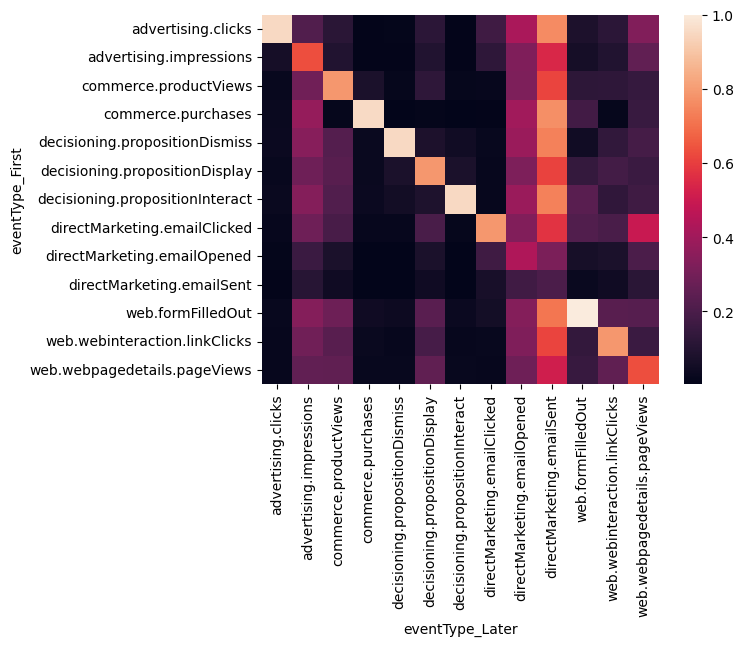

In [51]:
import seaborn as sns

pivoted = cocc_with_individual.pivot("eventType_First", "eventType_Later", "probability")
sns.heatmap(pivoted)


## 6.3 A more robust correlation calculation

Let's use an in-built feature of the query service (the Spark functions) to get a better handle of correlations between various eventTypes. We'll usee the `corr` function - which computes pearson correlation coefficients between a given eventType, and the target eventType

#### Run on the full dataset

In [52]:
large_correlation_query=f'''
SELECT SUM(webFormsFilled) as webFormsFilled_totalUsers,
       SUM(advertisingClicks) as advertisingClicks_totalUsers,
       SUM(productViews) as productViews_totalUsers,
       SUM(productPurchases) as productPurchases_totalUsers,
       SUM(propositionDismisses) as propositionDismisses_totaUsers,
       SUM(propositionDisplays) as propositionDisplays_totaUsers,
       SUM(propositionInteracts) as propositionInteracts_totalUsers,
       SUM(emailClicks) as emailClicks_totalUsers,
       SUM(emailOpens) as emailOpens_totalUsers,
       SUM(webLinkClicks) as webLinksClicks_totalUsers,
       SUM(webPageViews) as webPageViews_totalusers,
       corr(webFormsFilled, emailOpens) as webForms_EmalOpens,
       corr(webFormsFilled, advertisingClicks) as webForms_advertisingClicks,
       corr(webFormsFilled, productViews) as webForms_productViews,
       corr(webFormsFilled, productPurchases) as webForms_productPurchases,
       corr(webFormsFilled, propositionDismisses) as webForms_propositionDismisses,
       corr(webFormsFilled, propositionInteracts) as webForms_propositionInteracts,
       corr(webFormsFilled, emailClicks) as webForms_emailClicks,
       corr(webFormsFilled, emailOpens) as webForms_emailOpens,
       corr(webFormsFilled, emailSends) as webForms_emailSends,
       corr(webFormsFilled, webLinkClicks) as webForms_webLinkClicks,
       corr(webFormsFilled, webPageViews) as webForms_webPageViews
FROM(
    SELECT _{tenant_id}.cmle_id as userID,
            SUM(CASE WHEN eventType='web.formFilledOut' THEN 1 ELSE 0 END) as webFormsFilled,
            SUM(CASE WHEN eventType='advertising.clicks' THEN 1 ELSE 0 END) as advertisingClicks,
            SUM(CASE WHEN eventType='commerce.productViews' THEN 1 ELSE 0 END) as productViews,
            SUM(CASE WHEN eventType='commerce.productPurchases' THEN 1 ELSE 0 END) as productPurchases,
            SUM(CASE WHEN eventType='decisioning.propositionDismiss' THEN 1 ELSE 0 END) as propositionDismisses,
            SUM(CASE WHEN eventType='decisioning.propositionDisplay' THEN 1 ELSE 0 END) as propositionDisplays,
            SUM(CASE WHEN eventType='decisioning.propositionInteract' THEN 1 ELSE 0 END) as propositionInteracts,
            SUM(CASE WHEN eventType='directMarketing.emailClicked' THEN 1 ELSE 0 END) as emailClicks,
            SUM(CASE WHEN eventType='directMarketing.emailOpened' THEN 1 ELSE 0 END) as emailOpens,
            SUM(CASE WHEN eventType='directMarketing.emailSent' THEN 1 ELSE 0 END) as emailSends,
            SUM(CASE WHEN eventType='web.webinteraction.linkClicks' THEN 1 ELSE 0 END) as webLinkClicks,
            SUM(CASE WHEN eventType='web.webinteraction.pageViews' THEN 1 ELSE 0 END) as webPageViews
    FROM {table_name}
    GROUP BY userId
)
'''
large_correlation_df = qs_cursor.query(large_correlation_query, output="dataframe")
large_correlation_df

,webFormsFilled_totalUsers,advertisingClicks_totalUsers,productViews_totalUsers,productPurchases_totalUsers,propositionDismisses_totaUsers,propositionDisplays_totaUsers,propositionInteracts_totalUsers,emailClicks_totalUsers,emailOpens_totalUsers,webLinksClicks_totalUsers,...,webForms_advertisingClicks,webForms_productViews,webForms_productPurchases,webForms_propositionDismisses,webForms_propositionInteracts,webForms_emailClicks,webForms_emailOpens,webForms_emailSends,webForms_webLinkClicks,webForms_webPageViews
0,14841,6376,31545,0,2554,31639,2540,42431,198474,31501,...,-0.006571,0.228957,None,0.049756,0.132518,0.246498,0.094207,0.027688,0.21801,None


In [53]:
cols = large_correlation_df.columns
corrdf = large_correlation_df[[col for col in cols if ("webForms_"  in col)]].melt()
corrdf["feature"] = corrdf["variable"].apply(lambda x: x.replace("webForms_", ""))
corrdf["pearsonCorrelation"] = corrdf["value"]

corrdf.fillna(0)

,variable,value,feature,pearsonCorrelation
0,webForms_EmalOpens,0.094207,EmalOpens,0.094207
1,webForms_advertisingClicks,-0.006571,advertisingClicks,-0.006571
2,webForms_productViews,0.228957,productViews,0.228957
3,webForms_productPurchases,0.000000,productPurchases,0.000000
4,webForms_propositionDismisses,0.049756,propositionDismisses,0.049756
5,webForms_propositionInteracts,0.132518,propositionInteracts,0.132518
6,webForms_emailClicks,0.246498,emailClicks,0.246498
7,webForms_emailOpens,0.094207,emailOpens,0.094207
8,webForms_emailSends,0.027688,emailSends,0.027688
9,webForms_webLinkClicks,0.218010,webLinkClicks,0.218010


Let's visualize the results:

Text(0.5, 1.0, 'Pearson Correlation of Events with the outcome event')

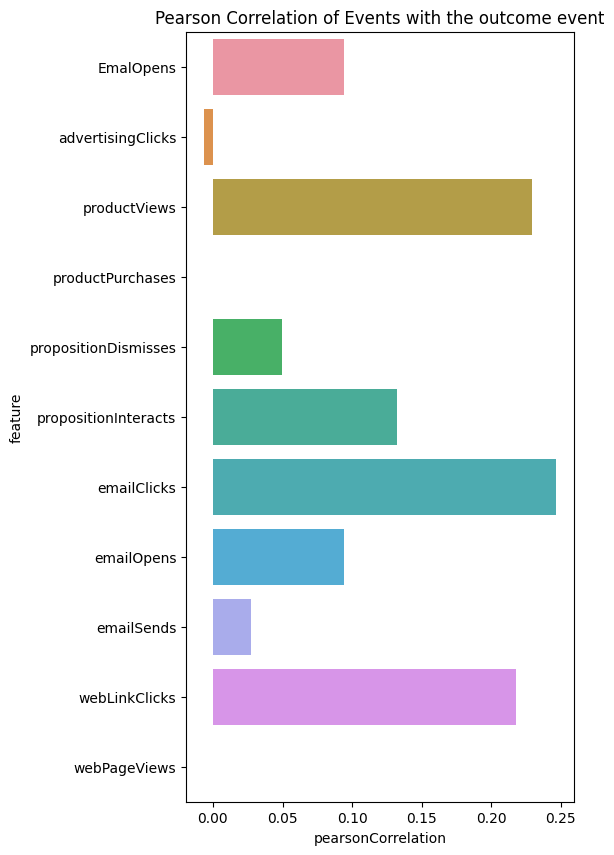

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(data=corrdf.fillna(0), y="feature", x="pearsonCorrelation")
ax.set_title("Pearson Correlation of Events with the outcome event")

<div class="alert alert-block alert-success">
    <b>Conclusion</b>
With this information, we now have a hypothesis on necessary features to use in our model.
We will use the number of these various event types, as well as the recency of each event type as features 
for the model. The next step is to create these "featurized" datasets
</div>

In [4]:
## 4.4 Saving the synthetic dataset to the configuration

Now that we got everything working, we just need to save the `dataset_id` variable in the original configuration file, so we can refer to it in the following weekly assignments. To do that, execute the code below:

In [ ]:
config.set("Platform", "dataset_id", dataset_id)

with open(config_path, "w") as configfile:
    config.write(configfile)